In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()


In [12]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [13]:
# hyper parameters
import random
block_size = 3 # context length: how many previous tokens will be used to predict the next
emb_dim = 10  # dimension of embedding vector
h_size = 300  # size of hidden layer
epochs = 200000
batch_size = 64


def build_dataset(words):
    ins, outs = [], []

    for w in words:
        # for w in words[:5]:
        # print(w)
        context = [0] * block_size  # init empty context for first word
        for ch in (w+'.'):
            ix = stoi[ch]
            ins.append(context)
            outs.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]  # move forward in context

    ins = torch.tensor(ins)
    outs = torch.tensor(outs)
    print(ins.shape, outs.shape)
    return ins, outs


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

in_train, out_train = build_dataset(words[:n1])
in_val, out_val = build_dataset(words[n1:n2])
in_test, out_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
# two dimensional embedding for each 27 characters
C = torch.randn((len(itos), emb_dim))
# hidden layer
# 100 neurons in the hidden layer, each with an input of (3 context len * 2-dim vector)
W1 = torch.randn(((block_size*emb_dim), h_size))* (5/3) / ((block_size*emb_dim)**0.5) # kaiming init
b1 = torch.randn(h_size) 						* 0.01
# output layer
W2 = torch.randn((h_size, len(itos))) 			* 0.01
b2 = torch.randn(len(itos)) 					* 0

bn_gain = torch.ones((1, h_size))
bn_bias = torch.zeros((1, h_size))

parameters = [C, W1, b1, W2, b2, bn_bias, bn_gain]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)


18297

In [15]:
# decreasing learning rate
lre = torch.linspace(-1, -3, epochs)
lrs = 10**lre


In [16]:
lri = []
lossi = []
stepi = []

for i in range(epochs):
	# minibatch
	ix = torch.randint(0, in_train.shape[0], (batch_size,))
	in_b, out_b = in_train[ix], out_train[ix]

	# forward pass
	emb = C[in_b]
	emb_cat = emb.view(-1, (block_size*emb_dim))
	h_preact = emb_cat @ W1 + b1 	# hidden layer pre-activation
	h_preact = bn_gain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bn_bias # batch norm
	h = torch.tanh(h_preact) 		# hidden layer
	logits = h @ W2 + b2 			# output layer
	loss = F.cross_entropy(logits, out_b)
	# print(loss.item())

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = lrs[i]
	# lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/{epochs:7d}: {loss.item():.4f} with lr: {lr:.4f}')
	lossi.append(loss.log10().item())
	stepi.append(i)
	# break

      0/ 200000: 3.2991 with lr: 0.1000
  10000/ 200000: 2.3108 with lr: 0.0794
  20000/ 200000: 2.0310 with lr: 0.0631
  30000/ 200000: 2.3336 with lr: 0.0501
  40000/ 200000: 1.9389 with lr: 0.0398
  50000/ 200000: 2.0744 with lr: 0.0316
  60000/ 200000: 2.3658 with lr: 0.0251
  70000/ 200000: 2.0324 with lr: 0.0200
  80000/ 200000: 2.0788 with lr: 0.0158
  90000/ 200000: 2.3416 with lr: 0.0126
 100000/ 200000: 2.1703 with lr: 0.0100
 110000/ 200000: 1.9491 with lr: 0.0079
 120000/ 200000: 1.9012 with lr: 0.0063
 130000/ 200000: 1.8428 with lr: 0.0050
 140000/ 200000: 2.0276 with lr: 0.0040
 150000/ 200000: 1.9821 with lr: 0.0032
 160000/ 200000: 2.0516 with lr: 0.0025
 170000/ 200000: 1.7809 with lr: 0.0020
 180000/ 200000: 2.1492 with lr: 0.0016
 190000/ 200000: 2.2565 with lr: 0.0013


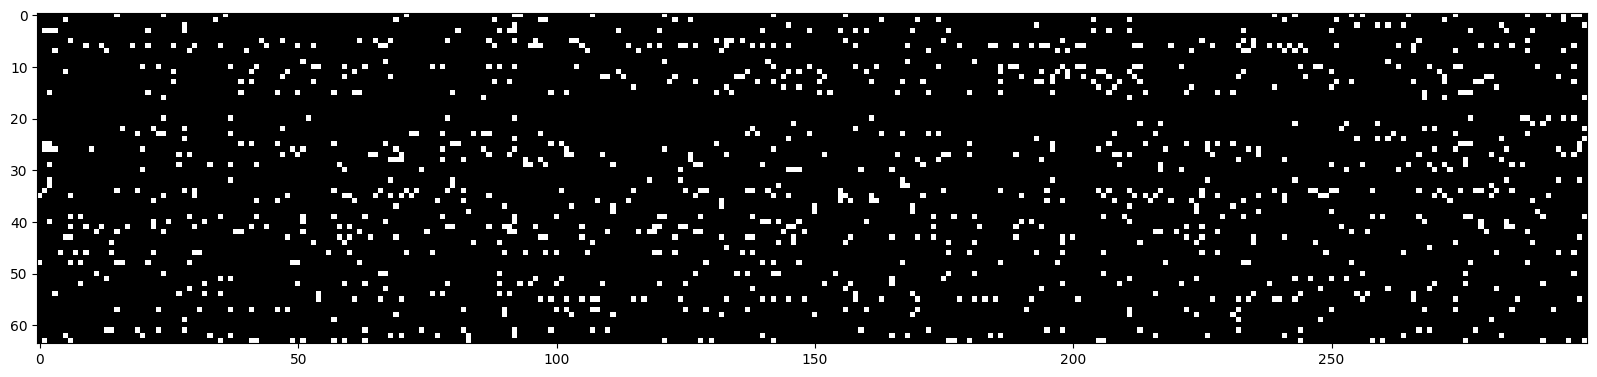

In [17]:
# if most neurons in the hidden layer has activations that falls on the flat regions of the tanh graph
# therefore that neuron does not learn and is useless
# if a column here is all white, it means all inputs are at the extreme and that neuron is dead
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([1434.,  782.,  611.,  488.,  434.,  370.,  373.,  417.,  308.,
         325.,  308.,  269.,  273.,  344.,  240.,  254.,  272.,  284.,
         235.,  282.,  252.,  203.,  265.,  187.,  253.,  214.,  231.,
         253.,  248.,  271.,  280.,  314.,  304.,  282.,  289.,  262.,
         280.,  277.,  321.,  301.,  322.,  326.,  307.,  432.,  433.,
         432.,  517.,  575.,  801., 1465.]),
 array([-9.99958634e-01, -9.59960361e-01, -9.19962087e-01, -8.79963813e-01,
        -8.39965539e-01, -7.99967265e-01, -7.59968991e-01, -7.19970717e-01,
        -6.79972444e-01, -6.39974170e-01, -5.99975896e-01, -5.59977622e-01,
        -5.19979348e-01, -4.79981074e-01, -4.39982800e-01, -3.99984527e-01,
        -3.59986253e-01, -3.19987979e-01, -2.79989705e-01, -2.39991431e-01,
        -1.99993157e-01, -1.59994884e-01, -1.19996610e-01, -7.99983358e-02,
        -4.00000620e-02, -1.78813934e-06,  3.99964857e-02,  7.99947596e-02,
         1.19993033e-01,  1.59991307e-01,  1.99989581e-01,  2.399878

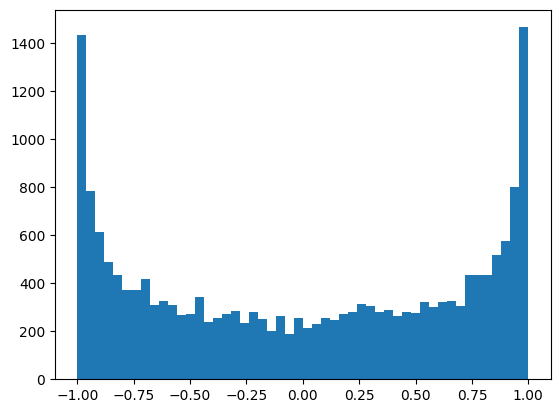

In [18]:
plt.hist(h.view(-1).tolist(), 50)

(array([2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 1.100e+01,
        1.200e+01, 9.000e+00, 1.900e+01, 3.900e+01, 4.500e+01, 1.100e+02,
        1.250e+02, 1.370e+02, 1.920e+02, 2.950e+02, 3.540e+02, 4.010e+02,
        5.420e+02, 5.960e+02, 7.790e+02, 8.900e+02, 9.930e+02, 1.116e+03,
        1.167e+03, 1.305e+03, 1.339e+03, 1.169e+03, 1.218e+03, 1.074e+03,
        1.051e+03, 8.970e+02, 7.930e+02, 5.800e+02, 4.600e+02, 3.560e+02,
        2.910e+02, 2.280e+02, 1.780e+02, 1.350e+02, 8.400e+01, 5.700e+01,
        4.600e+01, 3.200e+01, 3.300e+01, 2.200e+01, 6.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00]),
 array([-7.24998856, -6.9753941 , -6.70079964, -6.42620518, -6.15161072,
        -5.87701626, -5.6024218 , -5.32782734, -5.05323288, -4.77863842,
        -4.50404396, -4.2294495 , -3.95485504, -3.68026058, -3.40566612,
        -3.13107166, -2.8564772 , -2.58188274, -2.30728828, -2.03269382,
        -1.75809937, -1.48350491, -1.20891045, -0.93431599, -0.65972153,
        -0.

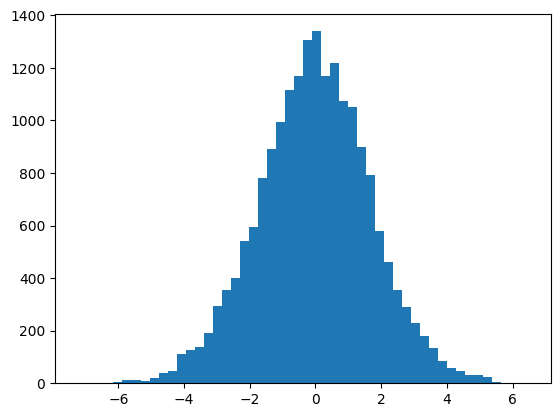

In [19]:
plt.hist((emb_cat @ W1 + b1).view(-1).tolist(), 50)

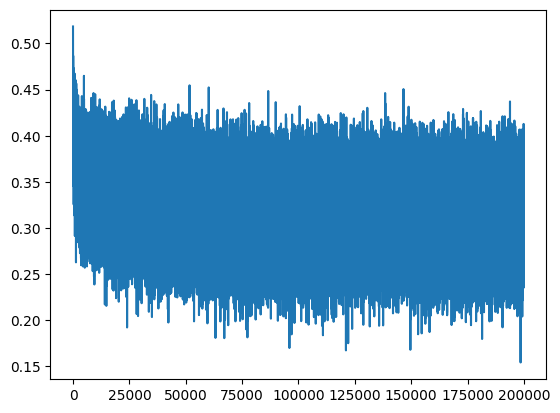

In [20]:
plt.plot(stepi, lossi)

In [21]:
@torch. no_grad() # this decorator disables gradient tracking
def split_loss (split):
	x, y = {
		'train': (in_train, out_train),
		'val': (in_val, out_val),
		'test': (in_test, out_test),
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	embcat = emb.view(emb.shape[0], -1) # concat into (N, block_ size * n_embd)
	h_preact = embcat @ W1 + b1
	h_preact = bn_gain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bn_bias # batch norm
	h = torch.tanh(h_preact) # (N, n_hidden)
	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print (split, loss.item())

split_loss('train')
split_loss ('val')

train 2.046654224395752
val 2.0981533527374268


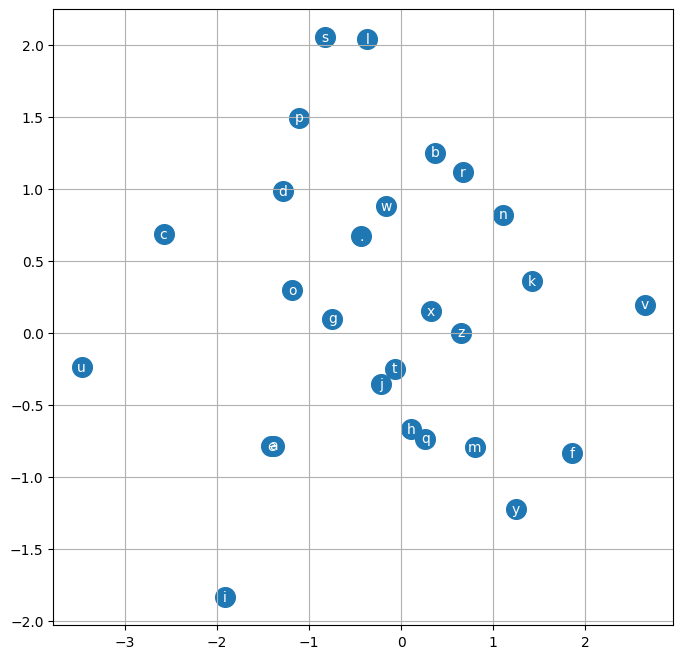

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color='white')
plt.grid('minor')


In [23]:
# sampling from model
g = torch.Generator().manual_seed(1001+1)
for i in range(20):
    out = []
    s_context = [0] * block_size
    while True:
        s_emb = C[torch.tensor([s_context])]
        s_h = torch.tanh(s_emb.view(1, -1) @ W1 + b1)
        s_logits = s_h @ W2 + b2
        s_probs = F.softmax(s_logits, dim=1)
        s_ix = torch.multinomial(s_probs, num_samples=1, generator=g).item()
        s_context = s_context[1:] + [s_ix]
        out.append(s_ix)
        if s_ix == 0:
            break
    print(''.join(itos[i] for i in out))


quandhyzekharmellen.
tyxdevindynmelwaylah.
chhsolplelycchkith.
darmonnivi.
tacchaspbyzambhlyfarek.
khaddvallo.
hogbndcytunah.
brip.
chlynabsevaj.
mahmarglynn.
jhon.
judxylah.
margolpthard.
gicelma.
qubhton.
quyvingstmpumwarithrynzxrifvadymqurnylah.
shmarqua.
criyaqudlary.
kaivid.
hizabrexsefagh.
